In [ ]:
import os
import cv2
import glob
import math
import time
import keras
import random
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from pathlib import Path
import keras.backend as K
from functools import lru_cache
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from collections import defaultdict, Counter
from sklearn.preprocessing import LabelEncoder
from keras.metrics import Precision, Recall, AUC
from concurrent.futures import ThreadPoolExecutor
from keras.utils import plot_model, to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.layers import Dropout,Conv2D, Input, MaxPool2D, add, Flatten, Dense, DepthwiseConv2D

In [5]:
dataset = Path(r"/kaggle/input/")
covid_19 = dataset / "covid19-radiography-database" / "COVID-19_Radiography_Dataset"
chest_xray = dataset / "chest-xray-pneumonia" / "chest_xray"
tb_chest = dataset / "tuberculosis-tb-chest-xray-dataset" / "TB_Chest_Radiography_Database"

In [6]:
class_mapping = defaultdict(list)

In [7]:
def append_file_names(directory, cls_name):
    """
    Append file names from a given directory to the corresponding class in the class_mapping dictionary.

    Args:
        directory (str): Directory path.
        cls_name (str): Name of the class.
    """
    for f_name in os.listdir(directory):
        if f_name.endswith((".jpeg", ".png")):
            class_mapping[cls_name].append(os.path.join(directory, f_name))

In [8]:
for covid19_class in [entry.name for entry in os.scandir(covid_19) if entry.is_dir()]:
    append_file_names(covid_19 / f"{covid19_class}" / 'images', f"{covid19_class}")

In [9]:
pneumonia_dirs = [chest_xray / "train" / "PNEUMONIA",
                  chest_xray / "test" / "PNEUMONIA",
                  chest_xray / "val" / "PNEUMONIA"]
for source_dir in pneumonia_dirs:
    for filename in os.listdir(source_dir):
        if filename.endswith(".jpeg"):
            if "bacteria" in filename:
                class_mapping["Bacterial Pneumonia"].append(os.path.join(source_dir, filename))

In [10]:
append_file_names(tb_chest / "Tuberculosis", "Tuberculosis")

In [11]:
classes = list(class_mapping.keys())
image_paths = []
labels = []

for class_name, file_paths in class_mapping.items():
    for file_path in tqdm(file_paths, desc=f"Processing {class_name}"):
        image_paths.append(file_path)
        labels.append(class_name)

Processing Tuberculosis: 100%|██████████| 700/700 [00:00<00:00, 721024.75it/s]


In [12]:
def is_black_and_white(image):
    """
    Check if the given image is black and white (grayscale).

    Parameters:
        image (PIL.Image.Image): The image object to check.

    Returns:
        bool: True if the image is black and white, False otherwise.
    """
    return image.mode == 'L'

In [13]:
def process_image(image_path, label):
    """
    Process a single image and return the color type.

    Parameters:
        image_path (str): File path of the image.
        label: Class label of the image.

    Returns:
        tuple: A tuple containing the label and color type ('Black & White' or 'Colored').
    """
    with Image.open(image_path) as image:
        color_type = 'Black & White' if is_black_and_white(image) else 'Colored'
    return label, color_type

def count_images_per_class(image_paths, labels):
    """
    Count the number of black and white and colored images per class.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.

    Returns:
        pandas.DataFrame: DataFrame containing the counts per class in tabular format.
    """
    data = defaultdict(lambda: {'Black & White': 0, 'Colored': 0})

    with ThreadPoolExecutor() as executor:
        processed_results = list(tqdm(executor.map(process_image, image_paths, labels), total=len(image_paths), desc="Processing images"))

    for label, color_type in processed_results:
        data[label][color_type] += 1

    df = pd.DataFrame(data).transpose().reset_index()
    df = df.rename(columns={'index': 'Class'})
    return df

In [14]:
result_df = count_images_per_class(image_paths, labels)
print(result_df)

Processing images: 100%|██████████| 24645/24645 [00:27<00:00, 910.12it/s] 


                 Class  Black & White  Colored
0               Normal          10192        0
1         Lung_Opacity           6012        0
2      Viral Pneumonia           1205      140
3                COVID           3616        0
4  Bacterial Pneumonia           2637      143
5         Tuberculosis            308      392


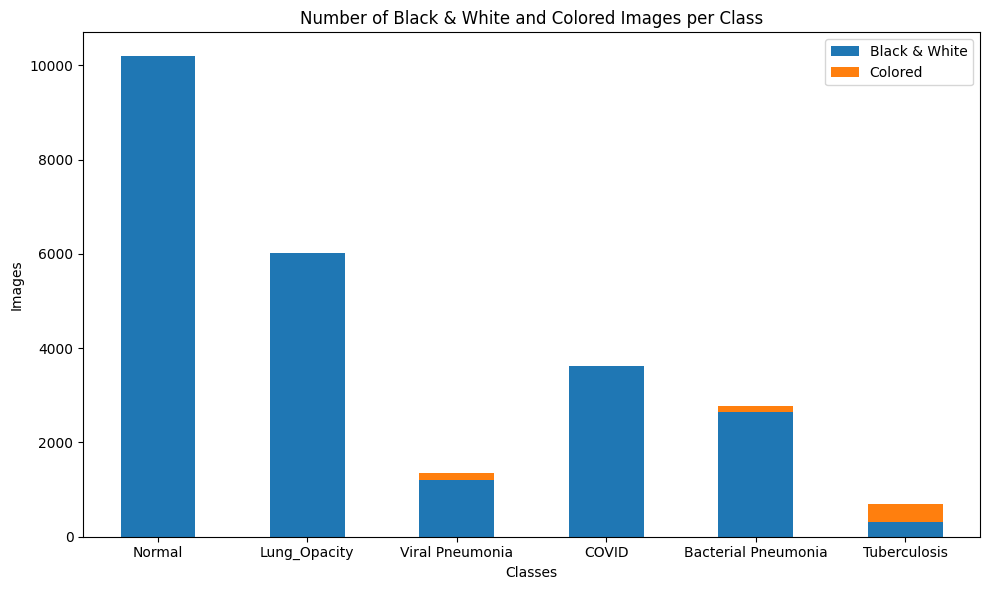

In [15]:
def visualize_images_per_class(result_df, class_column='Class', bw_column='Black & White', colored_column='Colored'):
    """
    Visualize the number of black and white images and colored images per class.

    Parameters:
        result_df (pandas.DataFrame): DataFrame containing the counts per class.
        class_column (str): Name of the column containing the class labels.
        bw_column (str): Name of the column containing the count of black and white images.
        colored_column (str): Name of the column containing the count of colored images.

    Returns:
        None
    """
    result_df.set_index(class_column, inplace=True)

    ax = result_df.plot(kind='bar', stacked=True, figsize=(10, 6), rot=0)
    ax.set_xlabel('Classes')
    ax.set_ylabel('Images')
    ax.set_title('Number of Black & White and Colored Images per Class')
    ax.legend(["Black & White", "Colored"])

    plt.tight_layout()
    plt.show()

visualize_images_per_class(result_df)

Loading and displaying images: 100%|██████████| 6/6 [00:00<00:00, 171.97it/s]


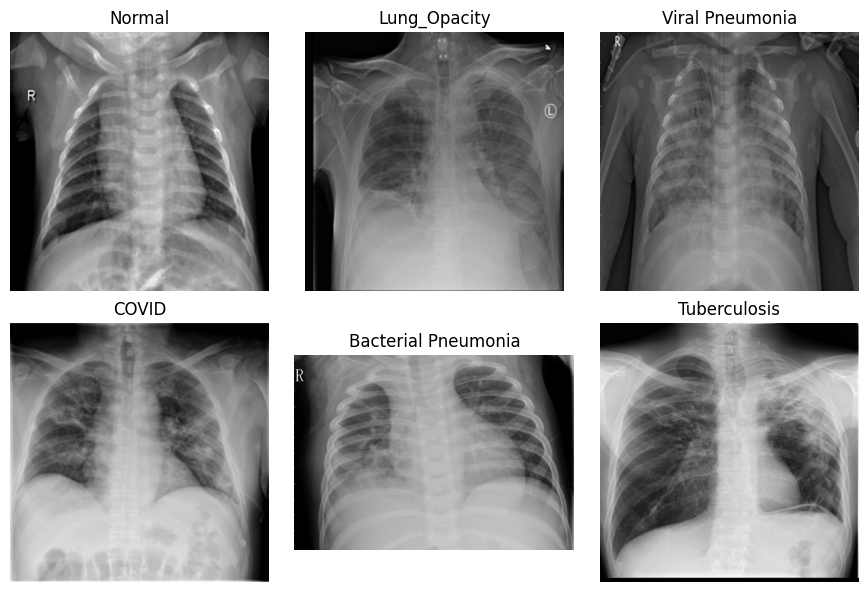

In [16]:
def group_images_by_class(image_paths, labels):
    """
    Group image paths by class label.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.

    Returns:
        dict: A dictionary where the keys are class labels, and the values are lists of image paths for each class.
    """
    class_to_images = {}
    for img_path, label in zip(image_paths, labels):
        if label not in class_to_images:
            class_to_images[label] = []
        class_to_images[label].append(img_path)
    return class_to_images

def display_images_per_class(image_paths, labels):
    """
    Display images grouped by class labels.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.
    """
    class_to_images = group_images_by_class(image_paths, labels)
    num_classes = len(class_to_images)

    num_rows = num_classes // 3
    num_cols = min(3, num_classes)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows))

    if num_rows == 1:
        axs = [axs]

    with tqdm(total=num_classes, desc="Loading and displaying images") as pbar:
        for i, (class_label, image_paths_for_class) in enumerate(class_to_images.items()):
            if i >= num_classes:
                break

            selected_image_path = random.choice(image_paths_for_class)
            try:
                selected_image = Image.open(selected_image_path)
                ax = axs[i // num_cols][i % num_cols]
                ax.imshow(selected_image, cmap='gray')
                ax.set_title(class_label)
                ax.axis('off')
            except Exception as e:
                print(f"Error loading image: {selected_image_path}")
                print(e)

            pbar.update(1)

    plt.tight_layout()
    plt.show()

display_images_per_class(image_paths, labels)

Displaying Images: 100%|██████████| 6/6 [00:20<00:00,  3.50s/it]


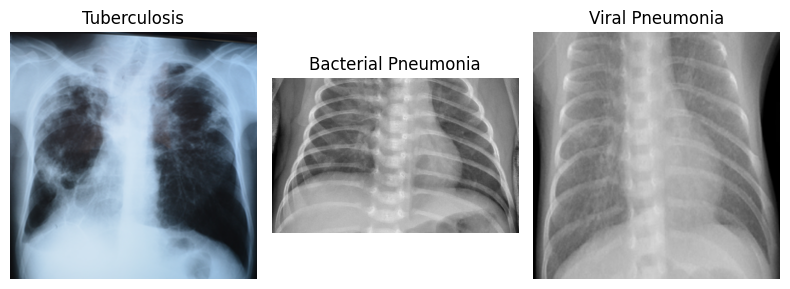

In [17]:
@lru_cache(maxsize=100)
def load_colored_image(image_path):
    """
    Load an image using Pillow and check if it is a colored image (not grayscale).

    Parameters:
        image_path (str): The path to the image file.

    Returns:
        numpy.ndarray or None: The loaded colored image as a NumPy array, or None if grayscale.
    """
    try:
        img = Image.open(image_path)
        if not is_black_and_white(img):
            return np.array(img)
    except (IOError, OSError) as e:
        raise Exception(f"Error loading image '{image_path}': {e}")
    return None

def display_colored_images(image_paths, labels, num_images_per_class=1):
    """
    Randomly display colored images for each class.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.
        num_images_per_class (int): Number of images to display per class.

    Returns:
        None
    """
    plt.figure(figsize=(8, 6))
    displayed_classes = 0
    unique_labels = set(labels)

    shuffled_labels = list(unique_labels)
    random.shuffle(shuffled_labels)

    for class_label in tqdm(shuffled_labels, desc="Displaying Images"):
        image_paths_for_class = [img_path for img_path, lbl in zip(image_paths, labels) if lbl == class_label]
        colored_images_for_class = [img_path for img_path in image_paths_for_class if load_colored_image(img_path) is not None]

        if len(colored_images_for_class) == 0:
            continue

        num_images_to_display = min(len(colored_images_for_class), num_images_per_class)

        for i in range(num_images_to_display):
            selected_image_path = random.choice(colored_images_for_class)
            selected_image = load_colored_image(selected_image_path)

            displayed_classes += 1
            plt.subplot(2, 3, displayed_classes)
            plt.imshow(selected_image)
            plt.title(f"{class_label}")
            plt.axis('off')

            if displayed_classes == 6:
                break

        if displayed_classes == 6:
            break

    plt.tight_layout()
    plt.show()

display_colored_images(image_paths, labels, num_images_per_class=1)

In [18]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
classes = label_encoder.classes_
num_classes = len(classes)

In [19]:
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths,
                                                                      labels_encoded,
                                                                      test_size=0.1,
                                                                      random_state=42,
                                                                      stratify=labels_encoded)

train_paths, test_paths, train_labels, test_labels= train_test_split(train_paths,
                                                                    train_labels,
                                                                    test_size=0.2222,
                                                                    random_state=42,
                                                                    stratify=train_labels)

In [20]:
train_df = pd.DataFrame({'File Paths': train_paths, 'Labels': train_labels})
val_df = pd.DataFrame({'File Paths': val_paths, 'Labels': val_labels})
test_df = pd.DataFrame({'File Paths': test_paths, 'Labels': test_labels})

total_train_samples = len(train_df)
total_val_samples = len(val_df)
total_test_samples = len(test_df)

train_percentage = (total_train_samples / len(labels_encoded)) * 100
val_percentage = (total_val_samples / len(labels_encoded)) * 100
test_percentage = (total_test_samples / len(labels_encoded)) * 100

train_counts = train_df['Labels'].value_counts().sort_index()
val_counts = val_df['Labels'].value_counts().sort_index()
test_counts = test_df['Labels'].value_counts().sort_index()

train_df = pd.DataFrame({'Train Samples': train_counts})
val_df = pd.DataFrame({'Validation Samples': val_counts})
test_df = pd.DataFrame({'Test Samples': test_counts})

train_df.index = val_df.index = test_df.index = classes

print("Total Train Samples:", total_train_samples)
print("Total Validation Samples:", total_val_samples)
print("Total Test Samples:", total_test_samples)
print("\nPercentage of Split:")
print("Train: {:.2f}%".format(train_percentage))
print("Validation: {:.2f}%".format(val_percentage))
print("Test: {:.2f}%".format(test_percentage))
print("\nClass Distribution:")
result_df = pd.concat([train_df, val_df, test_df], axis=1)
print(result_df)

Total Train Samples: 17251
Total Validation Samples: 2465
Total Test Samples: 4929

Percentage of Split:
Train: 70.00%
Validation: 10.00%
Test: 20.00%

Class Distribution:
                     Train Samples  Validation Samples  Test Samples
Bacterial Pneumonia           1946                 278           556
COVID                         2531                 362           723
Lung_Opacity                  4209                 601          1202
Normal                        7134                1019          2039
Tuberculosis                   490                  70           140
Viral Pneumonia                941                 135           269


In [21]:
def image_generator(img_paths, img_labels, batch_size):
    """Generator function to load and preprocess images in batches.

    Args:
        img_paths (list): List of image file paths.
        img_labels (list): List of corresponding image labels.
        batch_size (int): Size of the batch.

    Yields:
        tuple: A tuple containing the batch of images and their corresponding labels.
    """
    num_samples = len(img_paths)

    while True:
        for offset in range(0, num_samples, batch_size):
            batch_paths = img_paths[offset:offset + batch_size]
            batch_labels = img_labels[offset:offset + batch_size]

            batch_images = []
            for img_path in batch_paths:
                image = cv2.imread(str(img_path))
                resized_image = cv2.resize(image, (224, 224))
                normalized_image = resized_image / 255.0
                batch_images.append(normalized_image)

            yield np.array(batch_images), to_categorical(batch_labels, num_classes)

In [22]:
BATCH_SIZE = 16

train_generator = image_generator(train_paths, train_labels, BATCH_SIZE)
train_steps = len(train_paths) // BATCH_SIZE

val_generator = image_generator(val_paths, val_labels, BATCH_SIZE)
val_steps = len(val_paths) // BATCH_SIZE

test_generator = image_generator(test_paths, test_labels, BATCH_SIZE)
test_steps = len(test_paths) // BATCH_SIZE

In [23]:
def pepx_model(input_tensor, filters, name):
    """
    PEPXModel is a helper function that defines a specific structure of convolutional layers.

    Args:
        input_tensor (Tensor): Input tensor for the model.
        filters (int): Number of filters for the convolutional layers.
        name (str): Name prefix for the layers.

    Returns:
        Tensor: Output tensor of the model.
    """
    x = Conv2D(filters=filters, kernel_size=(1, 1), activation='relu', name=name + 'FP')(input_tensor)
    x = Conv2D(filters=filters, kernel_size=(1, 1), activation='relu', name=name + 'Expansion')(x)
    x = DepthwiseConv2D(kernel_size=(3, 3), activation='relu', padding='same', name=name + 'DWConv3_3')(x)
    x = Conv2D(filters=filters, kernel_size=(1, 1), activation='relu', name=name + 'SP')(x)
    x = Conv2D(filters=filters, kernel_size=(1, 1), activation='relu', name=name + 'Extension')(x)
    return x

In [24]:
def keras_model_build(input_size=(224, 224, 3)):
    """
    keras_model_build is a function that builds a specific Keras model architecture.

    Args:
        input_size (tuple): Size of the input tensor (height, width, channels).

    Returns:
        Model: Keras model object.
    """
    inp = Input(shape=input_size, name='input')
    x = Conv2D(input_shape=input_size, filters=64, kernel_size=(7, 7), activation='relu', padding='same',
               strides=(2, 2))(inp)
    x = MaxPool2D(pool_size=(2, 2))(x)

    p_1_y = Conv2D(256, (1, 1), padding='same', activation='relu', name='PEPX1_Conv')(x)

    y_1_1 = pepx_model(x, 256, 'PEPX1.1')
    y_1_2 = pepx_model(add([y_1_1, p_1_y]), 256, 'PEPX1.2')
    y_1_3 = pepx_model(add([y_1_1, y_1_2, p_1_y]), 256, 'PEPX1.3')

    p_2_y = Conv2D(512, (1, 1), padding='same', activation='relu', name='PEPX2_Conv')(add([p_1_y, y_1_1, y_1_2, y_1_3]))
    p_2_y = MaxPool2D(pool_size=(2, 2))(p_2_y)

    y_2_1 = pepx_model(add([y_1_3, y_1_2, y_1_1, p_1_y]), 512, 'PEPX2.1')
    y_2_1 = MaxPool2D(pool_size=(2, 2))(y_2_1)
    y_2_2 = pepx_model(add([y_2_1, p_2_y]), 512, 'PEPX2.2')
    y_2_3 = pepx_model(add([y_2_1, y_2_2, p_2_y]), 512, 'PEPX2.3')
    y_2_4 = pepx_model(add([y_2_1, y_2_2, y_2_3, p_2_y]), 512, 'PEPX2.4')

    p_3_y = Conv2D(1024, (1, 1), padding='same', activation='relu', name='PEPX3_Conv')(
        add([p_2_y, y_2_1, y_2_2, y_2_3, y_2_4])
    )
    p_3_y = MaxPool2D(pool_size=(2, 2))(p_3_y)

    y_3_1 = pepx_model(add([y_2_1, y_2_2, y_2_3, y_2_4, p_2_y]), 1024, 'PEPX3.1')
    y_3_1 = MaxPool2D(pool_size=(2, 2))(y_3_1)
    y_3_2 = pepx_model(y_3_1, 1024, 'PEPX3.2')
    y_3_3 = pepx_model(add([y_3_1, y_3_2]), 1024, 'PEPX3.3')
    y_3_4 = pepx_model(add([y_3_1, y_3_2, y_3_3]), 1024, 'PEPX3.4')
    y_3_5 = pepx_model(add([y_3_1, y_3_2, y_3_3, y_3_4]), 1024, 'PEPX3.5')
    y_3_6 = pepx_model(add([y_3_1, y_3_2, y_3_3, y_3_4, y_3_5]), 1024, 'PEPX3.6')

    p_4_y = Conv2D(2048, (1, 1), padding='same', activation='relu', name='PEPX4_Conv1')(
        add([p_3_y, y_3_1, y_3_2, y_3_3, y_3_4, y_3_5, y_3_6])
    )
    p_4_y = MaxPool2D(pool_size=(2, 2))(p_4_y)

    y_4_1 = pepx_model(add([y_3_1, y_3_2, y_3_3, y_3_4, y_3_5, y_3_6, p_3_y]), 2048, 'PEPX4.1')
    y_4_1 = MaxPool2D(pool_size=(2, 2))(y_4_1)
    y_4_2 = pepx_model(add([y_4_1, p_4_y]), 2048, 'PEPX4.2')
    y_4_3 = pepx_model(add([y_4_1, y_4_2, p_4_y]), 2048, 'PEPX4.3')

    fla = Flatten()(add([y_4_1, y_4_2, y_4_3, p_4_y]))

    d1 = Dense(1024, activation='relu')(fla)
    d2 = Dense(256, activation='relu')(d1)

    output = Dense(num_classes, activation='softmax')(d2)

    return keras.models.Model(inp, output)

In [25]:
model = keras_model_build()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['input[0][0]']               
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 56, 56, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 PEPX1.1FP (Conv2D)          (None, 56, 56, 256)          16640     ['max_pooling2d[0][0]']   

In [26]:
plot_model(model, show_shapes=True)

In [27]:
def create_metrics():
    """
    Creates instances of various metrics for evaluating model performance.

    Returns:
        tuple: A tuple of the metrics: (recall, precision, f1_score, auc, sensitivity, specificity, mcc).
    """
    @tf.function
    def f1_score(y_true, y_pred):
        """
        Calculates the F1 score.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: F1 score.
        """
        tp = true_positive(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        precision = tp / (tp + fp + K.epsilon())
        recall = tp / (tp + fn + K.epsilon())

        return 2 * (precision * recall) / (precision + recall + K.epsilon())

    @tf.function
    def specificity(y_true, y_pred):
        """
        Calculates the specificity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Specificity.
        """
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)

        return tn / (tn + fp + K.epsilon())

    @tf.function
    def sensitivity(y_true, y_pred):
        """
        Calculates the sensitivity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Sensitivity.
        """
        tp = true_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        return tp / (tp + fn + K.epsilon())

    @tf.function
    def mcc(y_true, y_pred):
        """
        Calculates the Matthews correlation coefficient (MCC).

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Matthews correlation coefficient.
        """
        tp = true_positive(y_true, y_pred)
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        numerator = (tp * tn - fp * fn)
        denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

        return numerator / (denominator + K.epsilon())

    @tf.function
    def true_positive(y_true, y_pred):
        """
        Calculates the number of true positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true positives.
        """
        y_pred_pos, _, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_pos)

    @tf.function
    def false_positive(y_true, y_pred):
        """
        Calculates the number of false positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false positives.
        """
        y_pred_pos, _, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_pos)

    @tf.function
    def false_negative(y_true, y_pred):
        """
        Calculates the number of false negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false negatives.
        """
        _, y_pred_neg, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_neg)

    @tf.function
    def true_negative(y_true, y_pred):
        """
        Calculates the number of true negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true negatives.
        """
        _, y_pred_neg, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_neg)

    @tf.function
    def calculate_confusion_matrix(y_true, y_pred):
        """
        Calculates the components of the confusion matrix.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            tuple: A tuple containing the components of the confusion matrix: (y_pred_pos, y_pred_neg, y_pos, y_neg).
        """
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.round(K.clip(y_true, 0, 1))
        y_neg = 1 - y_pos
        return y_pred_pos, y_pred_neg, y_pos, y_neg

    precision_metric = Precision()
    recall_metric = Recall()
    f1_score_metric = f1_score
    specificity_metric = specificity
    sensitivity_metric = sensitivity
    mcc_metric = mcc
    auc_metric = AUC()

    return (
        precision_metric,
        recall_metric,
        f1_score_metric,
        specificity_metric,
        sensitivity_metric,
        mcc_metric,
        auc_metric,
    )

In [28]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', create_metrics()]
)

In [29]:
class TimeCallback(tf.keras.callbacks.Callback):
    """Custom callback to record epoch times and total training time."""

    def on_train_begin(self, logs=None):
        """Initialize training start time and epoch times."""
        self.train_start_time = time.perf_counter()
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        """Record start time of each epoch."""
        self.epoch_start_time = time.perf_counter()

    def on_epoch_end(self, epoch, logs=None):
        """Calculate and store epoch time."""
        epoch_time = time.perf_counter() - self.epoch_start_time
        self.epoch_times.append(epoch_time)

    def on_train_end(self, logs=None):
        """Calculate total training time."""
        self.total_train_time = time.perf_counter() - self.train_start_time

time_callback = TimeCallback()

In [30]:
TOTAL_EPOCHS = 25

history = model.fit(
    train_generator,
    epochs=TOTAL_EPOCHS,
    steps_per_epoch=train_steps,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[time_callback]
)

Epoch 1/25
1078/1078 [==============================] - 528s 454ms/step - loss: 0.7660 - accuracy: 0.7035 - precision: 0.7832 - recall: 0.6112 - f1_score: 0.6687 - specificity: 0.9662 - sensitivity: 0.6112 - mcc: 0.6281 - auc: 0.9402 - val_loss: 0.5093 - val_accuracy: 0.8084 - val_precision: 0.8413 - val_recall: 0.7723 - val_f1_score: 0.8041 - val_specificity: 0.9709 - val_sensitivity: 0.7723 - val_mcc: 0.7691 - val_auc: 0.9726
Epoch 2/25
1078/1078 [==============================] - 488s 453ms/step - loss: 0.4784 - accuracy: 0.8219 - precision: 0.8460 - recall: 0.7926 - f1_score: 0.8175 - specificity: 0.9712 - sensitivity: 0.7927 - mcc: 0.7839 - auc: 0.9754 - val_loss: 0.4937 - val_accuracy: 0.8175 - val_precision: 0.8302 - val_recall: 0.7967 - val_f1_score: 0.8138 - val_specificity: 0.9676 - val_sensitivity: 0.7979 - val_mcc: 0.7782 - val_auc: 0.9744
Epoch 3/25
1078/1078 [==============================] - 468s 434ms/step - loss: 0.3764 - accuracy: 0.8592 - precision: 0.8752 - recall: 

In [31]:
execution_time_parts = []
avg_time_parts = []

for unit in [(3600, 'hours'), (60, 'minutes'), (1, 'seconds'), (0.001, 'milliseconds')]:
    total_value = int(time_callback.total_train_time // unit[0])
    avg_value = int(np.mean(time_callback.epoch_times) // unit[0])

    if total_value > 0 or unit[0] == 0.001:
        execution_time_parts.append((total_value, unit[1]))
    if avg_value > 0 or unit[0] == 0.001:
        avg_time_parts.append((avg_value, unit[1]))

    time_callback.total_train_time -= total_value * unit[0]
    time_callback.epoch_times = [time - avg_value * unit[0] for time in time_callback.epoch_times]

execution_time_string = ", ".join([
    f"{value:02d} {unit_str}" for value, unit_str in execution_time_parts if value > 0
])

avg_time_string = ", ".join([
    f"{value:02d} {unit_str}" for value, unit_str in avg_time_parts if value > 0
])

print(f"Model training took {execution_time_string}")
print(f"Average time per epoch: {avg_time_string}")

Model training took 03 hours, 20 minutes, 985 milliseconds
Average time per epoch: 08 minutes, 26 milliseconds


In [32]:
_ = model.evaluate(test_generator, steps=test_steps)

308/308 [==============================] - 43s 139ms/step - loss: 0.5741 - accuracy: 0.8849 - precision: 0.8851 - recall: 0.8845 - f1_score: 0.8848 - specificity: 0.9770 - sensitivity: 0.8845 - mcc: 0.8618 - auc: 0.9718


In [33]:
def plot_metrics(hist, metric_name_list):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        hist: a Keras History object containing the training history
        metric_name_list: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_name_list)

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, len(hist.history[metric_name_list[0]]) + 1)

    for ax, metric_n in zip(axes, metric_name_list):
        metric = hist.history[metric_n]
        v_metric = hist.history[f"val_{metric_n}"]

        ax.plot(rng, metric, label=metric_n)
        ax.plot(rng, v_metric, label=f"val_{metric_n}")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_n in ("auc", "mcc"):
            ax.set_ylabel(metric_n.upper())
            ax.set_title(metric_n.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_n.capitalize())
            ax.set_title(metric_n.capitalize() + " vs Epochs")

        max_loss = max(max(metric), max(v_metric))
        min_loss = min(min(metric), min(v_metric))
        y_max = math.ceil(max_loss)

        if min_loss > 0 or max_loss > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_loss, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, len(metric))

    plt.tight_layout()

    plt.show()

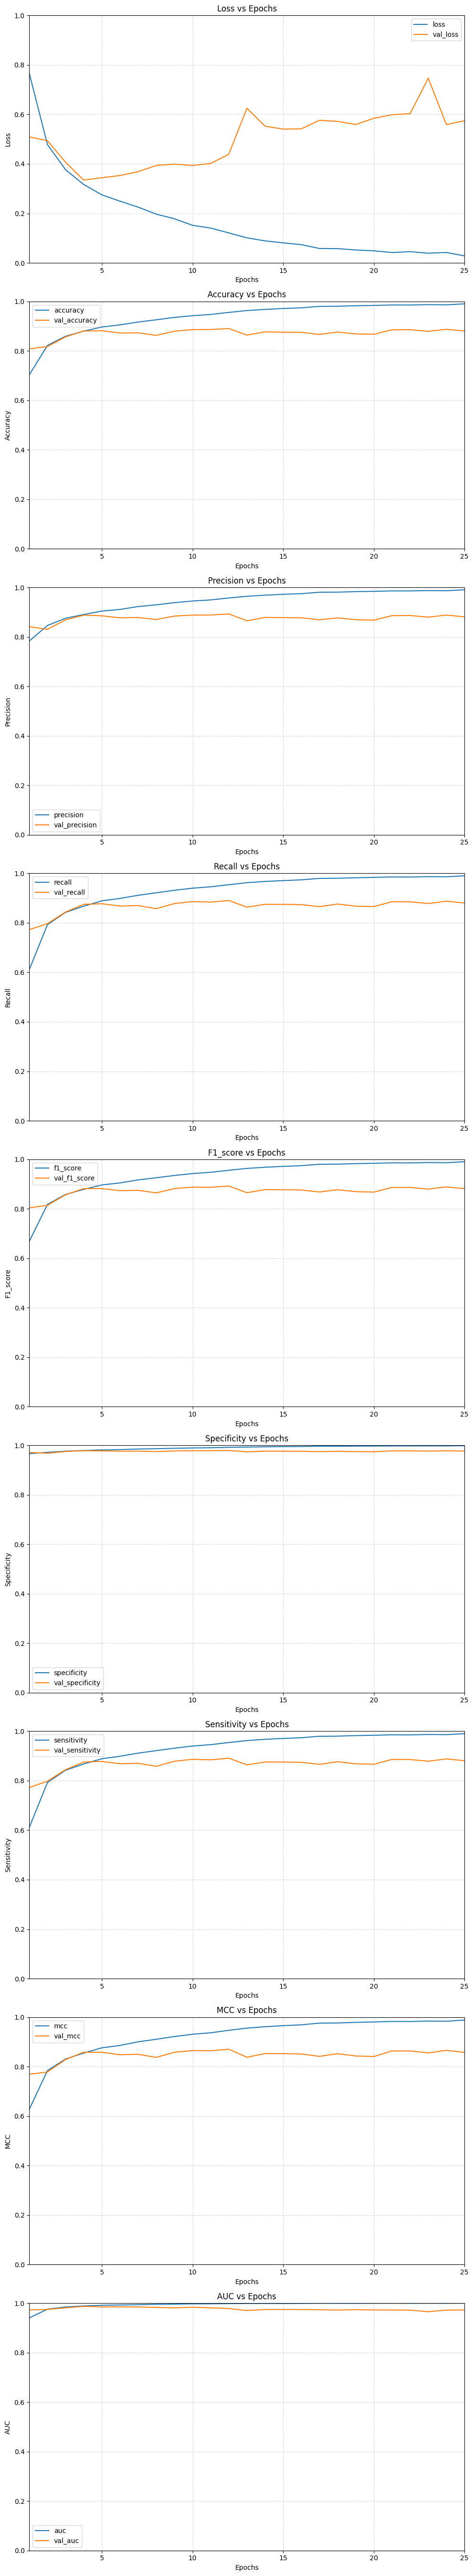

In [34]:
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
plot_metrics(history, metric_names)

In [35]:
def generate_classification_report(model, test_generator, test_steps, batch_size, target_names):
    """
    Generate a classification report, accuracy, and number of errors for a given model and test generator.

    Args:
        model (object): The trained model.
        test_generator (object): The test data generator.
        test_steps (int): The number of steps to iterate over the test generator.
        batch_size (int): The batch size for generating predictions.
        target_names (list): List of target class names for the classification report.

    Returns:
        tuple: A tuple containing true labels, predicted labels, and the classification report.
    """
    predicted_labels = []
    true_labels = []

    for i in range(test_steps):
        batch_data, batch_true_labels = next(test_generator)

        batch_predicted_labels = model.predict_on_batch(batch_data)
        batch_predicted_labels = np.argmax(batch_predicted_labels, axis=1)

        predicted_labels.extend(batch_predicted_labels)
        true_labels.extend(batch_true_labels)

    true_labels = np.array(true_labels)

    if len(true_labels[0]) > 1:
        true_labels = np.argmax(true_labels, axis=1)

    report = classification_report(
        true_labels,
        predicted_labels,
        target_names=target_names,
        digits=4,
        zero_division=1
    )

    accuracy = accuracy_score(true_labels, predicted_labels)
    num_errors = np.sum(true_labels != predicted_labels)

    print(report)
    print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

    return true_labels, predicted_labels

In [36]:
true_labels, predicted_labels = generate_classification_report(
    model, test_generator, test_steps, BATCH_SIZE, classes
)

                     precision    recall  f1-score   support

Bacterial Pneumonia     0.9575    0.9748    0.9661       555
              COVID     0.9393    0.9211    0.9301       722
       Lung_Opacity     0.7825    0.8604    0.8196      1196
             Normal     0.9072    0.8563    0.8810      2032
       Tuberculosis     0.9060    0.9643    0.9343       140
    Viral Pneumonia     0.9186    0.8843    0.9011       268

           accuracy                         0.8848      4913
          macro avg     0.9019    0.9102    0.9054      4913
       weighted avg     0.8878    0.8848    0.8855      4913

There were 566 errors in 4913 tests for an accuracy of  88.48


In [37]:
def confusion_matrix(true_labels, predicted_labels, num_classes):
    """
    Compute the confusion matrix.

    Args:
        true_labels (list or numpy.ndarray): Array-like object of true labels.
        predicted_labels (list or numpy.ndarray): Array-like object of predicted labels.
        num_classes (int): Number of classes.

    Returns:
        numpy.ndarray: Confusion matrix.
    """
    cm = np.zeros((num_classes, num_classes), dtype=int)
    np.add.at(cm, (true_labels, predicted_labels), 1)
    return cm

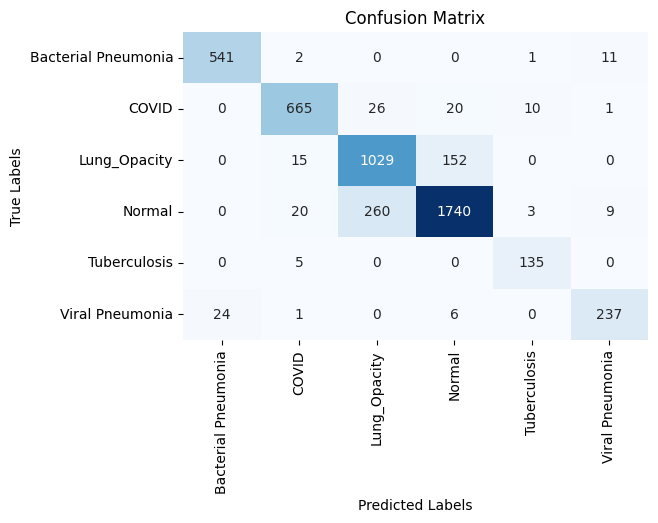

In [38]:
cm = confusion_matrix(true_labels, predicted_labels, num_classes)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()